# Experiment

## Prerequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog
- temps de deploiement vs nombre de fonctions
- la mémoire et le cpu au niveau du noeud fog

In [43]:
METRICS_PATH<-"metrics-default/"

In [44]:
#install.packages('IRkernel') # Requires the tk package
#IRkernel::installspec()  # to register the kernel in the current R installation

In [45]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)

Load the the Python `integration.py` script to use its variable in R

In [46]:
use_virtualenv('.venv/', required = TRUE)
import_from_path("monitoring", path = ".")

# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python('integration.py')) 

Module(monitoring)

Error in py_run_file_impl(file, local, convert) : SystemExit: 0



Load the graph network as an adjancency matrix

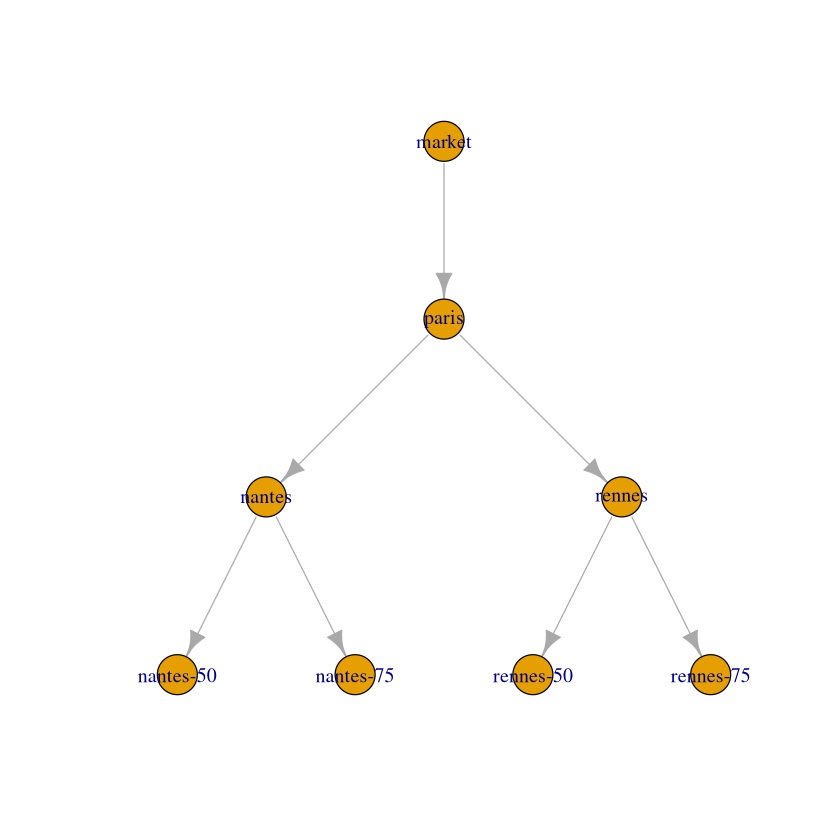

In [47]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret = matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }

  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout=layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)


## Data preprocessing

In [48]:
names_raw <- read.csv2(file = paste(METRICS_PATH,'names.csv',sep="/"), header = TRUE, sep = '\t')
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [49]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [50]:
mem <- read.csv2(file = paste(METRICS_PATH,'fog_node_memory_available.csv',sep="/"), header = TRUE, sep = '\t') %>%
    prepare %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    select(c(instance, value)) %>%
    mutate(dyn = formattable::percent(value / max(value, na.rm=TRUE))) %>%
    mutate(value = as.numeric(as.character(value)))

cpu <- read.csv2(file = paste(METRICS_PATH,'fog_node_cpu_used.csv', sep="/"), header = TRUE, sep = '\t') %>%
    prepare %>%
    select(c(instance, value)) %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    group_by(instance) %>%
    mutate(value = as.numeric(as.character(value)))


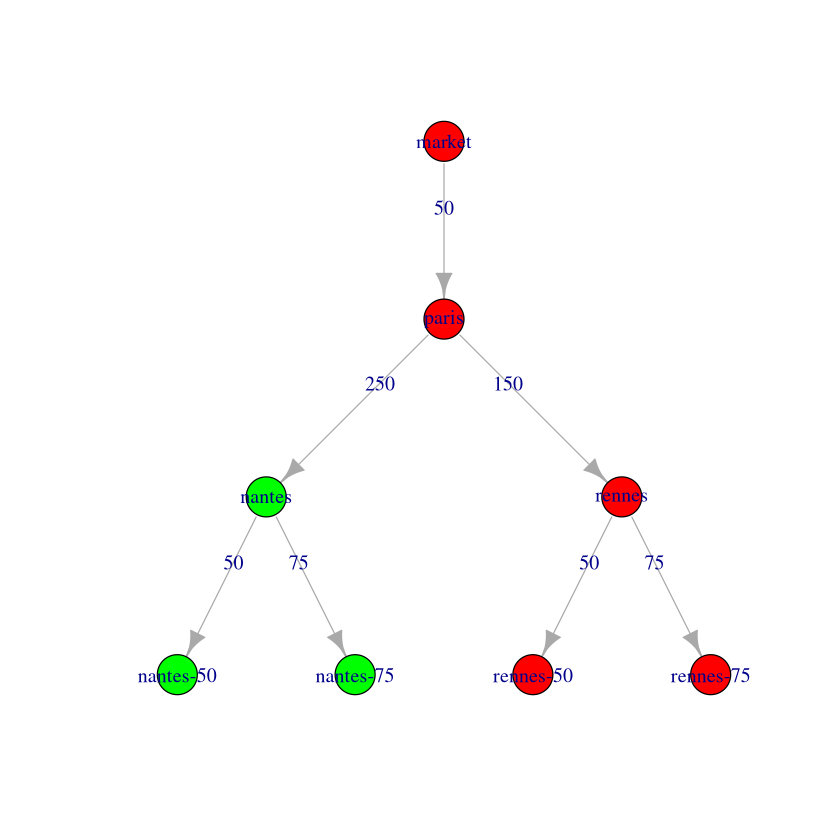

In [51]:
PercentageColourConnected <- function(x) { colorRampPalette(c('red', 'green'))(2)[ifelse(is.na(x), 1, 2)] }
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

Describe what nodes we have:
- size is the number of CPUs
- color is the RAM (purple is the max in the network)

Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”


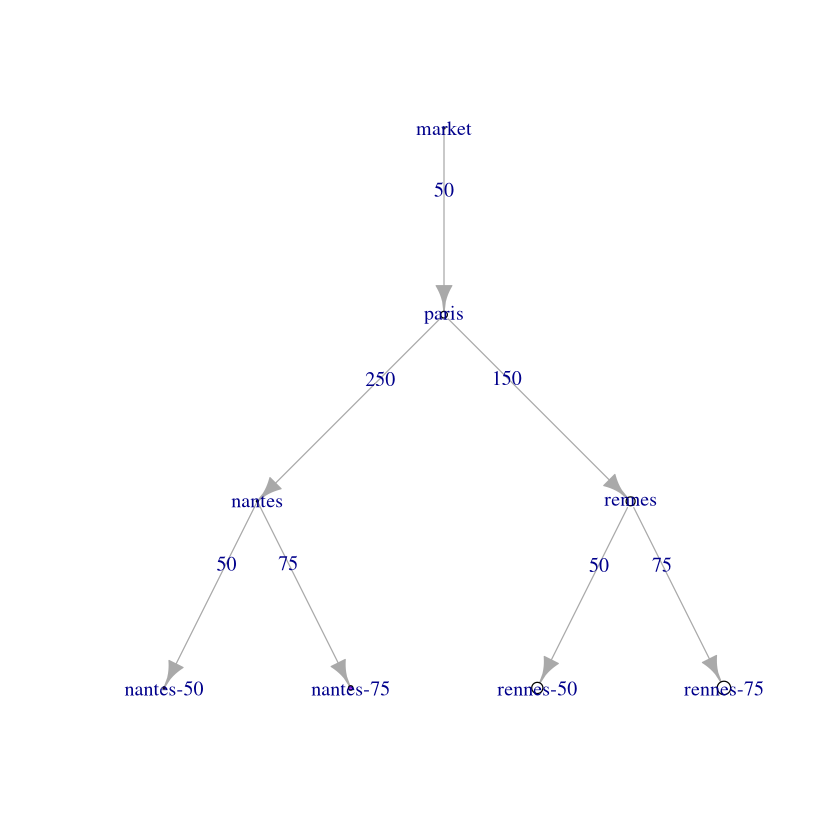

In [52]:
PercentageColour <- function(x){colorRampPalette(c('white','purple'))(101)[round(ifelse(is.na(x), 0, x)*100)+1]}
net_prez <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_prez)$size <- ifelse(is.na(cpu$value), 0, cpu$value * 8)
V(net_prez)$color <- PercentageColour(mem$dyn)
plot(net_prez, layout = layout_as_tree, edge.label = E(net_prez)$weight)

In [53]:
bids_raw <- read.csv2(file = paste(METRICS_PATH,'fog_node_bids.csv',sep="/"), header = TRUE, sep = '\t') %>%
prepare

head(bids_raw)

,instance,name,bid_id,function_name,job,timestamp,value,n
,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>
1,market,NA,NA,NA,NA,NA,NA,0
2,nantes,fog_node_bids,8e7ba79a-3af0-43be-8c41-57386c60352c,echo-8,telegraf,2022-07-27 16:32:43,0.1653693,0
3,nantes,fog_node_bids,8e7ba79a-3af0-43be-8c41-57386c60352c,echo-8,telegraf,2022-07-27 16:32:38,0.1653693,0
4,nantes,fog_node_bids,8e7ba79a-3af0-43be-8c41-57386c60352c,echo-8,telegraf,2022-07-27 16:32:53,0.1653693,0
5,nantes,fog_node_bids,8e7ba79a-3af0-43be-8c41-57386c60352c,echo-8,telegraf,2022-07-27 16:29:23,0.1653693,0
6,nantes,fog_node_bids,8e7ba79a-3af0-43be-8c41-57386c60352c,echo-8,telegraf,2022-07-27 16:33:13,0.1653693,0


instance,n
<chr>,<int>
nantes,7
nantes-50,6
nantes-75,7


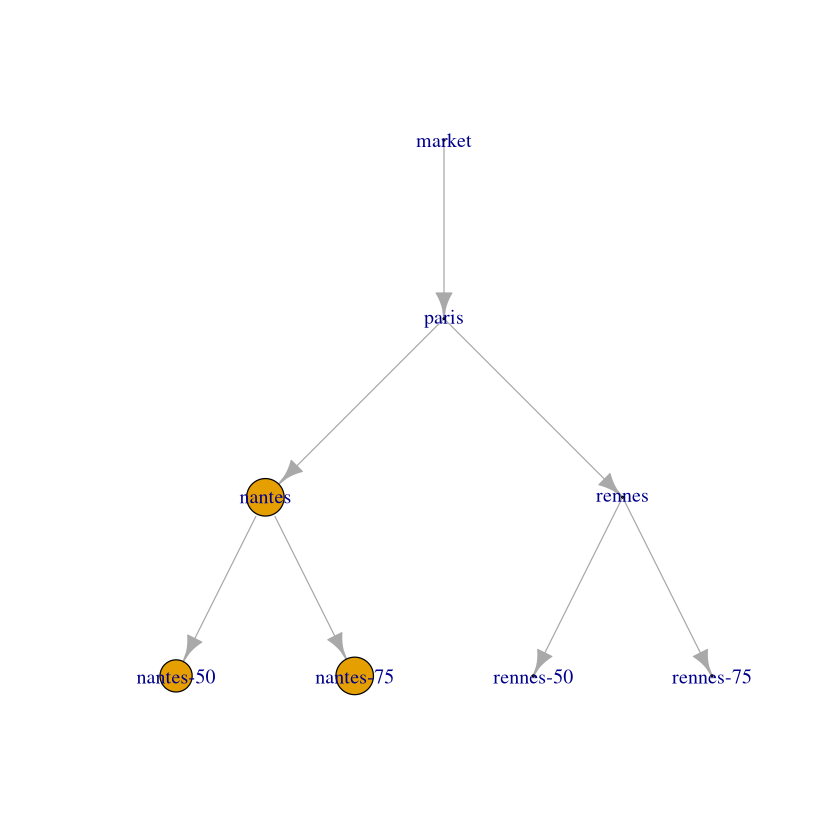

In [54]:
bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)


Plot the free memory

Warning message:
“Removed 5 row(s) containing missing values (geom_path).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


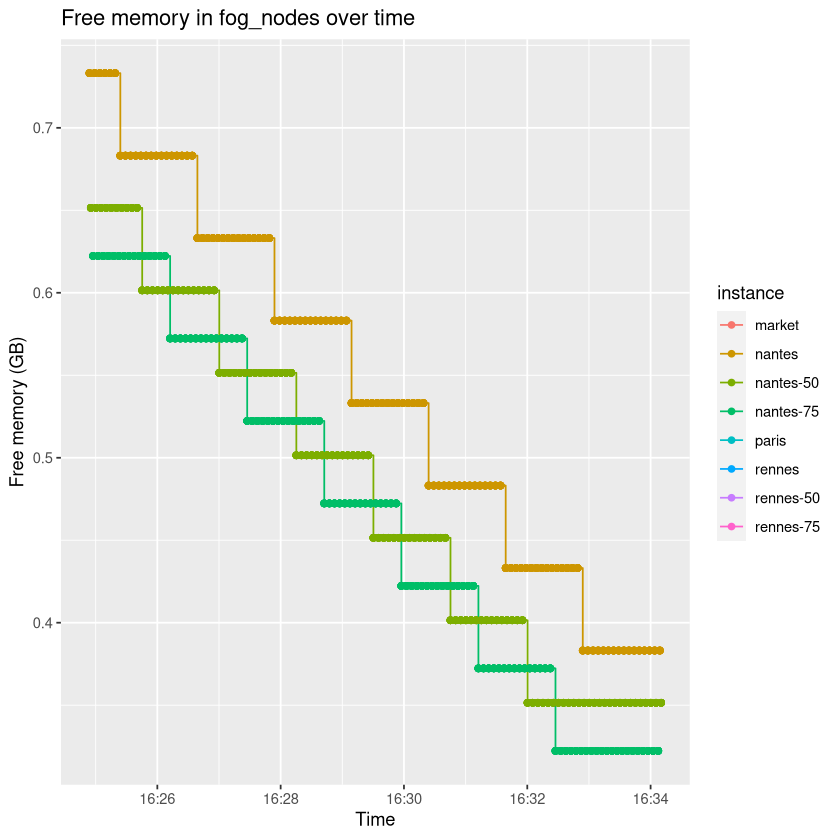

In [55]:
mem_used <- read.csv2(file = paste(METRICS_PATH,'fog_node_memory_used.csv', sep="/"), header = TRUE, sep = '\t') %>% prepare
mem_avail <- read.csv2(file = paste(METRICS_PATH,'fog_node_memory_available.csv', sep="/"), header = TRUE, sep = '\t') %>% prepare

mem_free <- mem_used %>%
        inner_join(mem_avail, by=c("instance", "timestamp")) %>%
        mutate(free = (value.y - value.x)/1e09) %>%
        select(instance, timestamp, free)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, color = instance)) +
  geom_step() +
  geom_point() +
  labs(x="Time", y="Free memory (GB)", title="Free memory in fog_nodes over time")

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

`summarise()` has grouped output by 'instance'. You can override using the
`.groups` argument.


instance,instance_to,mean_ms
<chr>,<chr>,<dbl>
market,paris,101
nantes,nantes-50,101
nantes,nantes-75,151
nantes,paris,501
nantes-50,nantes,101
nantes-75,nantes,151
paris,market,101
paris,nantes,501
paris,rennes,301


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



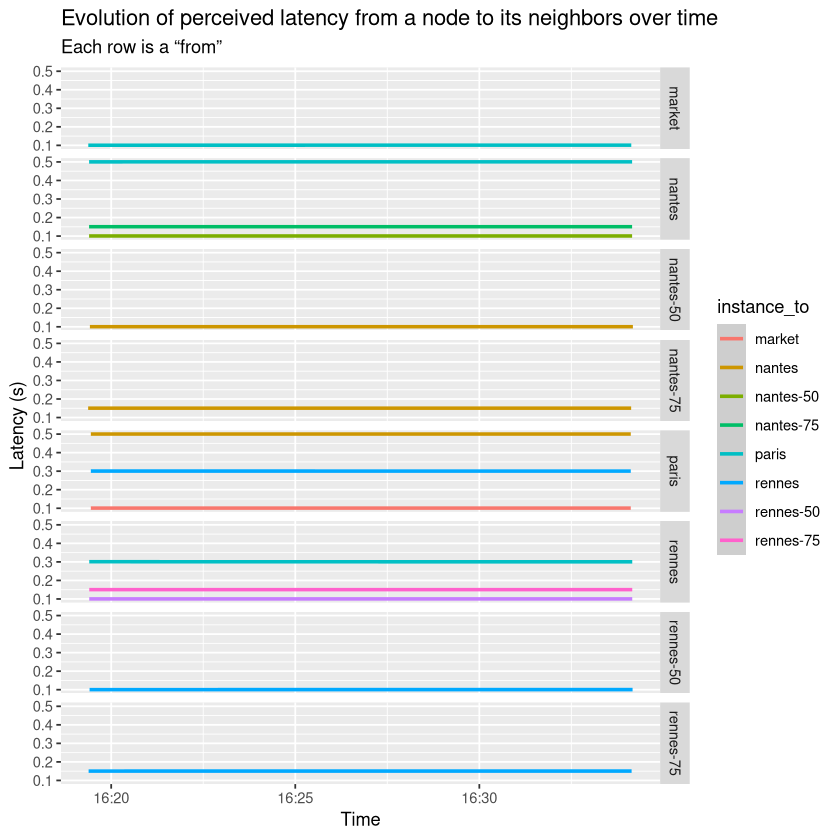

In [56]:
latency <- read.csv2(file = paste(METRICS_PATH,'fog_node_neighbors_latency_rolling_avg.csv',sep="/"), header = TRUE, sep = '\t') %>%
  prepare %>%
  mutate(instance_to = as.character(names[instance_to]))

latency %>%
  group_by(instance, instance_to) %>%
  summarise(mean_ms = round(mean(value*1000), 0))

latency %>%
  ggplot(aes(x = timestamp, y = value, color = instance_to)) +
  geom_smooth() +
  labs(x="Time", y="Latency (s)", title="Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
  facet_grid(rows = vars(instance))

In [57]:
bids_won_function <- read.csv2(file = paste(METRICS_PATH,'iot_emulation_http_request_duration_seconds_print_bucket.csv',sep="/"), header = TRUE, sep = '\t') %>%
  prepare %>%
  select(instance, tag, value, le, n)


In [58]:
head(bids_won_function)

,instance,tag,value,le,n
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,market,NA,NA,NA,0
2,nantes,NA,NA,NA,0
3,nantes-50,NA,NA,NA,0
4,nantes-75,NA,NA,NA,0
5,NULL,echo-1,1,+Inf,NA
6,NULL,echo-1,1,+Inf,NA


instance,name,bid_id,function_name,job,timestamp,value,n,winner
<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<chr>
nantes-75,fog_node_bids,05f26d59-43c4-4ff6-8e5b-8f9568151e11,echo-1,telegraf,2022-07-27 16:24:57,0.1371794,0,nantes-75
nantes-75,fog_node_bids,f1fa09b9-59ae-4f0e-a89e-fc515502a3f4,echo-10,telegraf,2022-07-27 16:28:42,0.1738048,0,nantes-75
nantes,fog_node_bids,ca899d4f-1d52-46de-a47c-df85dde7ae8a,echo-11,telegraf,2022-07-27 16:29:03,0.1797490,0,nantes
nantes-50,fog_node_bids,cb66ca14-fe7a-4b90-b012-7ad8ae77d163,echo-12,telegraf,2022-07-27 16:31:15,0.1847061,0,nantes-50
nantes-75,fog_node_bids,e3fad65b-1880-4692-a399-17e6e268c3df,echo-13,telegraf,2022-07-27 16:31:27,0.1909176,0,nantes-75
nantes,fog_node_bids,13598933-dc13-4bdd-9373-29cb22f68064,echo-14,telegraf,2022-07-27 16:30:18,0.1968690,0,nantes


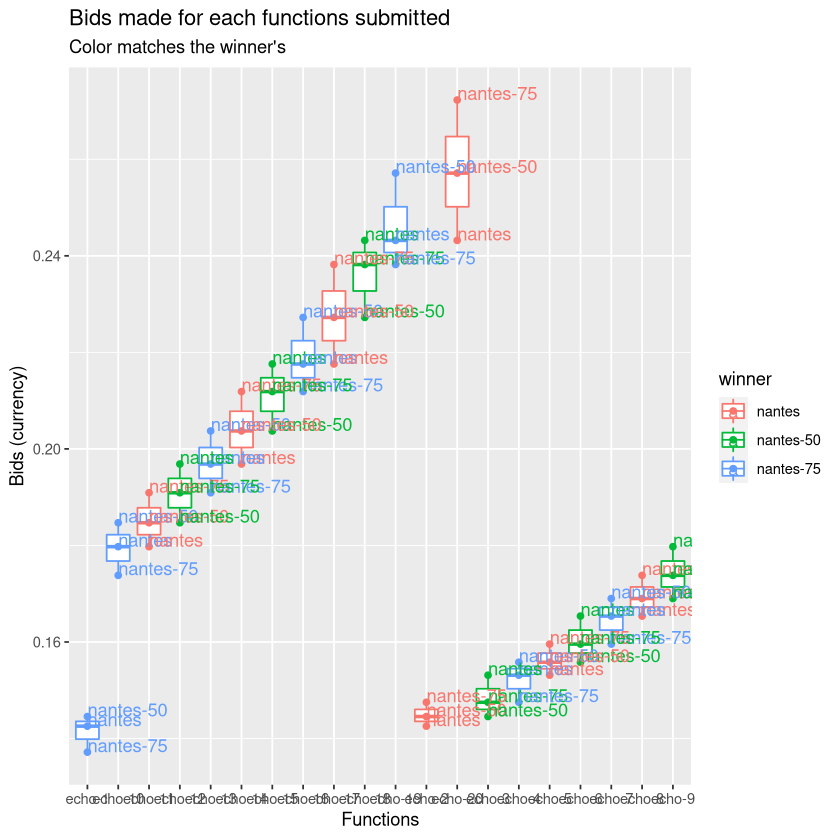

In [59]:
bids_won_function <- bids_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

head(bids_won_function)

bids_function <- bids_raw %>%
  select(c(instance, function_name, value)) %>%
  distinct() %>%
  inner_join(bids_won_function, by = c("function_name"))

bids_function %>%
  ggplot(aes(x = function_name, y = value.x, group = function_name, color = winner, label = instance.x)) +
  geom_boxplot() +
  geom_point() +
  geom_text(hjust = 0, vjust = 0) +
  labs(x="Functions", y="Bids (currency)", title="Bids made for each functions submitted", subtitle="Color matches the winner's")

,timestamp,avg,tag,winner
,<dttm>,<dbl>,<chr>,<chr>
1,2022-07-27 16:25:29,0.4066894,echo-1,nantes-75
2,2022-07-27 16:25:29,0.4066894,echo-1,nantes-75
3,2022-07-27 16:25:29,0.4066894,echo-1,nantes-75
4,2022-07-27 16:25:29,0.4066894,echo-1,nantes-75
5,2022-07-27 16:25:29,0.4066894,echo-1,nantes-75
6,2022-07-27 16:25:29,0.4066894,echo-1,nantes-75


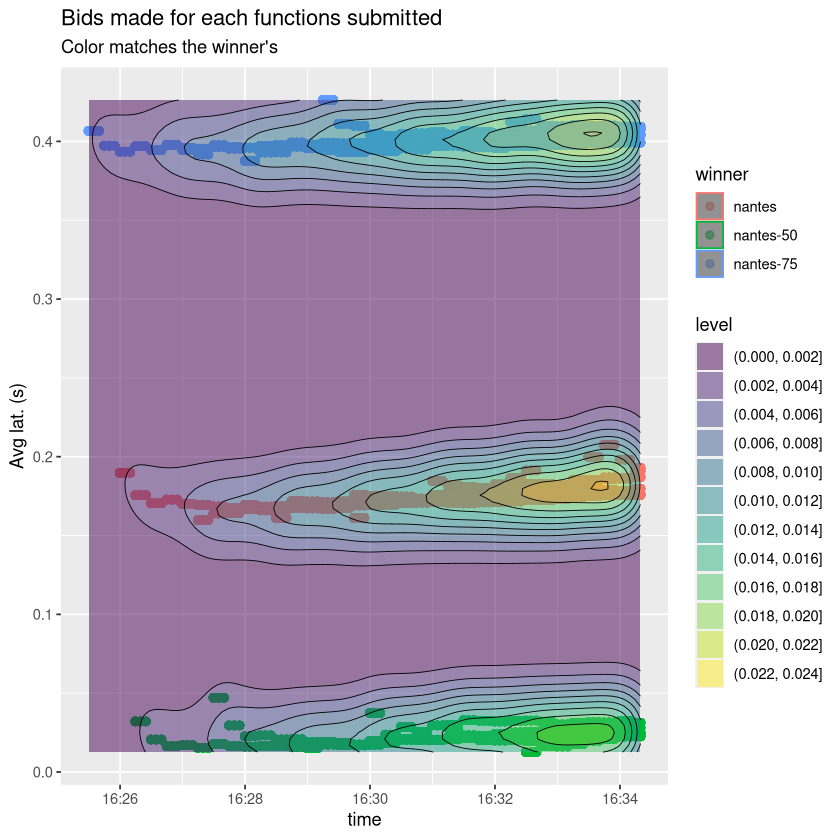

In [60]:
toto <- read.csv2(file = paste(METRICS_PATH,'iot_emulation_http_request_duration_seconds_print_sum.csv',sep="/"), header = TRUE, sep = '\t') %>%
  mutate(timestamp = as.numeric(as.character(timestamp))) %>%
  mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
  mutate(value = as.numeric(as.character(value)))


titi <- read.csv2(file = paste(METRICS_PATH,'iot_emulation_http_request_duration_seconds_print_count.csv',sep="/"), header = TRUE, sep = '\t') %>%
  mutate(timestamp = as.numeric(as.character(timestamp))) %>%
  mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
  mutate(value = as.numeric(as.character(value)))

tutu <- toto %>%
  inner_join(titi, by = c("instance", "job", "timestamp", "tag"), ) %>%
  mutate(avg = value.x/value.y) %>%
  select(timestamp, avg, tag) %>%
  filter(!is.na(avg)) %>%
  mutate(function_name=tag) %>%
  inner_join(bids_function %>% select(function_name, winner), by=c("function_name")) %>%
  select(timestamp, avg, tag, winner)

head(tutu)

tutu %>% 
  # ggplot(aes(x = timestamp, y = avg, group = tag, color = tag, label = tag)) +
  ggplot(aes(x=timestamp,y=avg)) +
  # geom_point() +
  geom_point(aes(color=winner), size=2, alpha = 0.5) +
  geom_density_2d_filled(alpha = 0.5) +
  geom_density_2d(size = 0.25, colour = "black") +
  # geom_bin_2d() +
  #geom_text(hjust = 0, vjust = 0) +
  labs(x="time", y="Avg lat. (s)", title="Bids made for each functions submitted", subtitle="Color matches the winner's")